## Data Assimilation of 1D Burgers' Data

In [1]:
import os
import sys
sys.path.append('..')

import flax
from flax.training import checkpoints
import jax
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import orbax.checkpoint as ocp
import seaborn as sns

import dps
from losses import get_constraint_losses_fn
import model_utils as namm_mutils
import pdes

from score_flow import losses as score_losses
from score_flow import utils
from score_flow.models import utils as score_mutils
from score_flow.models import ddpm, ncsnpp, ncsnv2

from configs import namm_config as namm_config_provider
from configs import score_config as score_config_provider

sns.set(font_scale=2)
sns.set_style('ticks')
palette = sns.color_palette('colorblind')

2025-02-07 14:44:34.946272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738968274.958857  382453 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738968274.962946  382453 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
n_samples = 32
sample_rng = jax.random.PRNGKey(100)
_, sample_rngs = utils.psplit(sample_rng)
cmap = 'viridis'

# The checkpoints of the models used for the paper were 
# saved with legacy Flax checkpointing instead of
# Orbax checkpointing.
use_orbax_checkpointing = False

finetune = True
if finetune:
  dm_epoch = 1500
  ft_epoch = 700
  mdm_epoch = 300
else:
  dm_epoch = 1300
  namm_epoch = 100
  mdm_epoch = 1000

workdir = '../checkpoints/Burgers_burgers/sparseicnn_cyc=1.0_reg=0.001_constr=1.0_maxsig=0.1_lr=2e-04_bs=16_layers=3_fwdnfilt=32_bwdnfilt=64'
dm_workdir = '../score_checkpoints/Burgers_64x64_ncsnpp_nf=64_vpsde_betamin=0.1_betamax=20.0'

## Load NAMM

In [3]:
# NAMM config:
namm_config = namm_config_provider.get_config()
namm_config.data.dataset = 'Burgers'
namm_config.data.height = 64
namm_config.data.width = 64
namm_config.data.num_channels = 1
namm_config.constraint.type = 'burgers'
namm_config.model.bwd_activation = 'softplus'
namm_config.model.bwd_residual = True
namm_config.model.fwd_icnn_n_layers = 3

image_shape = (namm_config.data.height, namm_config.data.width, namm_config.data.num_channels)
shape = (n_samples // jax.local_device_count(), *image_shape)

# Constraint distance function:
constr_losses_fn = get_constraint_losses_fn(namm_config)

In [4]:
# Get NAMM model.
namm_model = namm_mutils.get_model(namm_config)
namm_state = namm_mutils.init_state(namm_config, namm_model)
namm_state, _, _ = namm_mutils.init_optimizer(namm_config, namm_state)

# Restore NAMM checkpoint.
if finetune:
  namm_ckpt_path = os.path.join(os.getcwd(), workdir, 'finetune/namm/checkpoints')
  namm_epoch = ft_epoch
else:
  namm_ckpt_path = os.path.join(os.getcwd(), workdir, 'namm/checkpoints')
if use_orbax_checkpointing:
  ckpt_mgr = ocp.CheckpointManager(namm_ckpt_path)
  namm_state = ckpt_mgr.restore(namm_epoch, args=ocp.args.StandardRestore(namm_state))
else:
  namm_state = checkpoints.restore_checkpoint(
    os.path.join(namm_ckpt_path, f'checkpoint_{namm_epoch}'),
    namm_state)
assert namm_state.epoch == namm_epoch
print(f'NAMM epoch: {namm_state.epoch}')

@jax.jit
def inverse_mirror_fn(x):
  return namm_model.backward(
    {'dropout': jax.random.PRNGKey(0)}, namm_state.bwd_params, x, train=False)

NAMM epoch: 700


## Load MDM

In [5]:
score_config = score_config_provider.get_config()
score_config.data = namm_config.data
score_config.constraint = namm_config.constraint

# Initialize score model.
score_model, score_init_model_state, score_init_params = score_mutils.init_model(
  jax.random.PRNGKey(0), score_config)
score_tx = score_losses.get_optimizer(score_config)
score_opt_state = score_tx.init(score_init_params)
score_state = score_mutils.State(
  step=0,
  epoch=0,
  model_state=score_init_model_state,
  opt_state=score_opt_state,
  ema_rate=score_config.model.ema_rate,
  params=score_init_params,
  params_ema=score_init_params,
  rng=jax.random.PRNGKey(0))

# Restore MDM checkpoint.
mdm_ckpt_path = os.path.join(os.getcwd(), workdir, f'mdm/checkpoints')
if use_orbax_checkpointing:
  ckpt_mgr = ocp.CheckpointManager(mdm_ckpt_path)
  score_state = ckpt_mgr.restore(mdm_epoch, args=ocp.args.StandardRestore(score_state))
else:
  score_state = checkpoints.restore_checkpoint(
    os.path.join(mdm_ckpt_path, f'checkpoint_{mdm_epoch}'),
    score_state)
assert score_state.epoch == mdm_epoch
print('MDM epoch:', score_state.epoch)

score_pstate = flax.jax_utils.replicate(score_state)

sde, t0 = utils.get_sde(score_config)

# Get score function.
score_fn = score_mutils.get_score_fn(
    sde,
    score_model,
    score_state.params_ema,
    score_state.model_state,
    train=False,
    continuous=True)

MDM epoch: 300


## Forward model

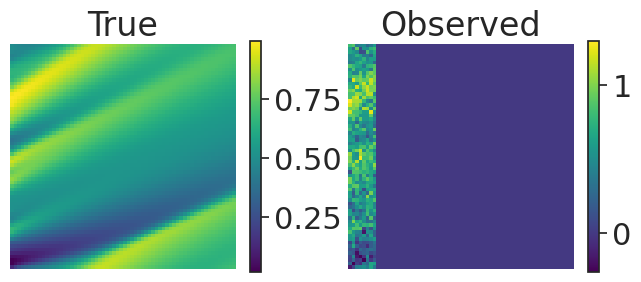

In [6]:
# To obtain measurements, we apply a mask to the image
# (keeping only the first 8 columns, or states) and add noise to 
# the observed states.

def forward_model(x):
  return x[:, :, :8, :]

sigma = 0.2  # measurement noise
def get_measurement(rng, x):
  y_clean = forward_model(x)
  y_noisy = y_clean + jax.random.normal(rng, y_clean.shape) * sigma
  return y_noisy

# Get ground-truth image.
X_test = np.load('../data/burgers_test_set.npy')
x_true = X_test[0]

# Simulate measurements.
meas_rng = jax.random.PRNGKey(0)
y = get_measurement(meas_rng, x_true[None, ...])[0]
y_full = np.zeros_like(x_true)
y_full[:, :8] = y

fig = plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(x_true, cmap=cmap)
plt.axis('off')
plt.colorbar()
plt.title('True')
plt.subplot(122)
plt.imshow(y_full, cmap=cmap)
plt.axis('off')
plt.colorbar()
plt.title('Observed')
plt.show()

## Mirror DPS

In [7]:
mirror_dps_sampler = dps.get_mirror_dps_sampler(
  y, forward_model, sigma, sde, score_fn,
  inverse_mirror_fn, shape, eps=t0)

In [8]:
scale = 0.05
%time y_samples = jax.device_get(mirror_dps_sampler(sample_rngs, scale))
samples = inverse_mirror_fn(y_samples)
samples = samples.reshape(n_samples, *image_shape)

CPU times: user 2min 3s, sys: 45.5 s, total: 2min 49s
Wall time: 49 s


## Vanilla DPS

In [9]:
# Restore DM checkpoint.
dm_ckpt_path = os.path.join(os.getcwd(), dm_workdir, 'checkpoints')
if use_orbax_checkpointing:
  ckpt_mgr = ocp.CheckpointManager(dm_ckpt_path)
  dm_score_state = ckpt_mgr.restore(dm_epoch, args=ocp.args.StandardRestore(score_state))
else:
  dm_score_state = checkpoints.restore_checkpoint(
    os.path.join(dm_ckpt_path, f'checkpoint_{dm_epoch}'),
    score_state)
assert dm_score_state.epoch == dm_epoch
print(f'DM epoch: {dm_score_state.epoch}')

# Get score function.
dm_score_fn = score_mutils.get_score_fn(
    sde,
    score_model,
    dm_score_state.params_ema,
    dm_score_state.model_state,
    train=False,
    continuous=True)

# Get DPS sampler.
dps_sampler = dps.get_dps_sampler(
  y, forward_model, sigma, sde, dm_score_fn, shape,
  eps=t0)

DM epoch: 1500


In [10]:
scale = 0.05
%time dps_samples = jax.device_get(dps_sampler(sample_rngs, scale))
dps_samples = dps_samples.reshape(n_samples, *image_shape)

# Filter out any samples that have NaNs.
dps_samples = dps.get_valid_samples(dps_samples)
print(f'{len(dps_samples)}/{n_samples} valid samples')

CPU times: user 52.2 s, sys: 32.5 s, total: 1min 24s
Wall time: 34.8 s
32/32 valid samples


## Constraint-guided DPS (CG-DPS)

In [11]:
cgdps_sampler = dps.get_dps_sampler(
  y, forward_model, sigma, sde, dm_score_fn, shape,
  constraint_weight=200, constraint_losses_fn=constr_losses_fn,
  eps=t0)

In [12]:
scale = 0.05
%time cgdps_samples = jax.device_get(cgdps_sampler(sample_rngs, scale))
cgdps_samples = cgdps_samples.reshape(n_samples, *image_shape)

# Filter out any samples that have NaNs.
cgdps_samples = dps.get_valid_samples(cgdps_samples)
print(f'{len(cgdps_samples)}/{n_samples} valid samples')

CPU times: user 53.2 s, sys: 33.1 s, total: 1min 26s
Wall time: 35.6 s
32/32 valid samples


## Evaluate results

### Compare constraint distances of estimated samples

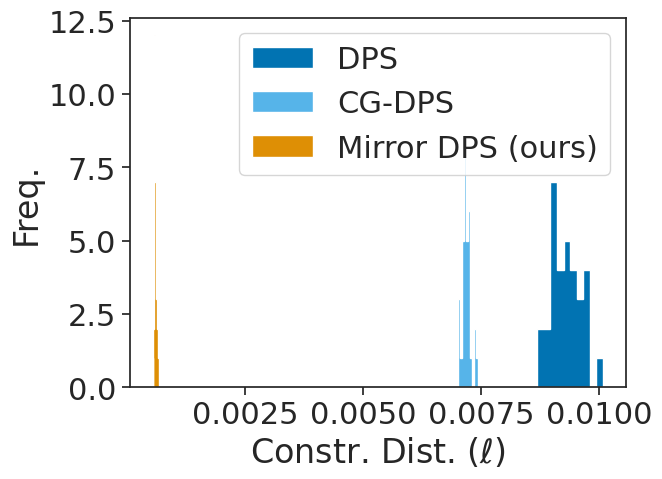

In [13]:
constr_losses = constr_losses_fn(samples)
dps_constr_losses = constr_losses_fn(dps_samples)
cgdps_constr_losses = constr_losses_fn(cgdps_samples)

plt.hist(dps_constr_losses, histtype='stepfilled', color=palette[0], label='DPS')
plt.hist(cgdps_constr_losses, histtype='stepfilled', color=palette[9], label='CG-DPS')
plt.hist(constr_losses, histtype='stepfilled', color=palette[1], label='Mirror DPS (ours)')
plt.legend()
plt.xlabel(r'Constr. Dist. ($\ell$)')
plt.ylabel('Freq.')
plt.show()

### Compare constraint residuals of estimated samples

In [14]:
# Get a function that gives us the residual from the 1D Burgers' constraint.
# We use the PDE parameters and discretization parameters that were used
# for our 1D Burgers' dataset and throughout our experiments.
residual_fn = pdes.get_burgers_residual_fn(
  mu=1, nu=0.05, x0=0, x1=10, nx=64, t0=0, dt=0.025, inner_steps=5, nt=64)

residuals = residual_fn(samples)
dps_residuals = residual_fn(dps_samples)
cgdps_residuals = residual_fn(cgdps_samples)

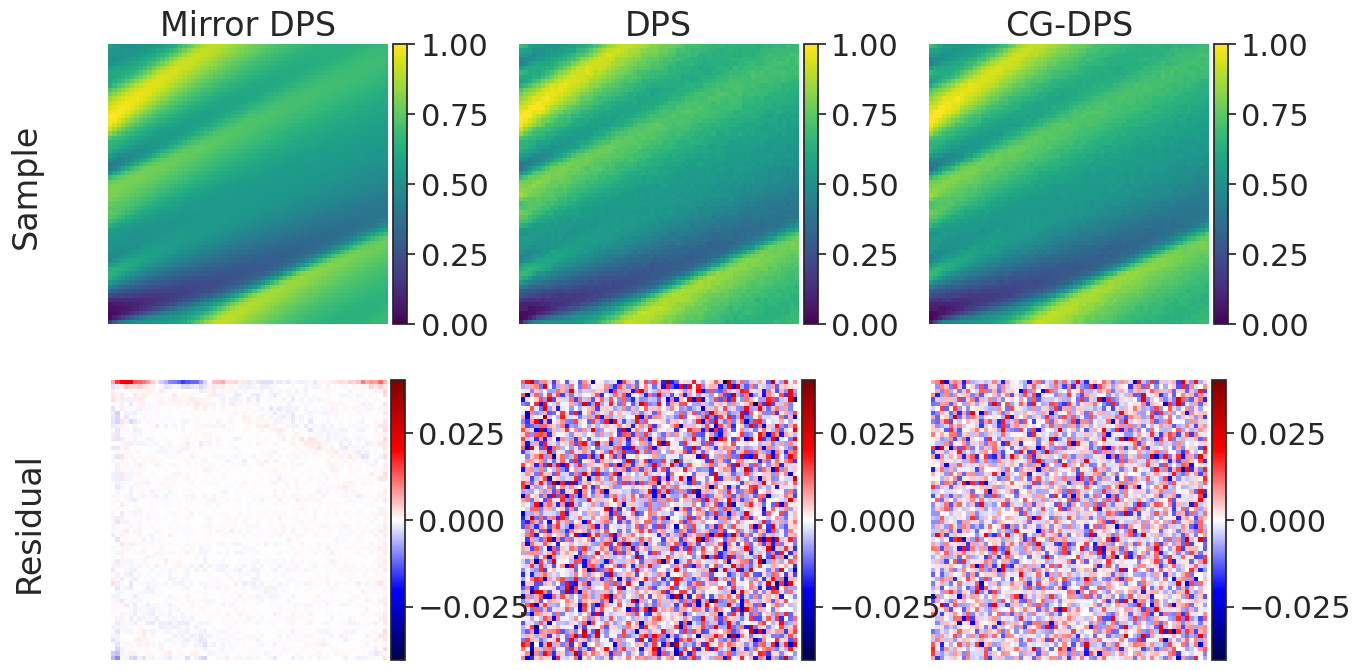

In [15]:
sample_idx = 0
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

methods = ['Mirror DPS', 'DPS', 'CG-DPS']
sample_per_method = [samples[sample_idx], dps_samples[sample_idx], cgdps_samples[sample_idx]]
residual_per_method = [residuals[sample_idx], dps_residuals[sample_idx], cgdps_residuals[sample_idx]]
max_residual = np.max(np.abs(residual_per_method))

for i, image in enumerate(sample_per_method):
  ax = axs[0, i]
  p = ax.imshow(image, clim=(0, 1), cmap=cmap)
  ax.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  fig.colorbar(p, cax=cax)
  ax.set_title(methods[i])
  if i == 0:
    ax.text(-0.3 * image_shape[1], 0.5 * image_shape[0], 'Sample', ha='center', va='center', rotation=90)
for i, image in enumerate(residual_per_method):
  ax = axs[1, i]
  p = ax.imshow(image, clim=(-max_residual, max_residual), cmap='seismic')
  ax.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  fig.colorbar(p, cax=cax)
  if i == 0:
    ax.text(-0.3 * image_shape[1], 0.5 * image_shape[0], 'Residual', ha='center', va='center', rotation=90)

plt.show()